# Most common fragments

## Aim of this notebook

This notebook contains the code that was used to analyze the most common fragments per subpocket as well as to generate the respective plots shown in the manuscript. 

- Find 50 most common fragments in each subpocket (if multiple fragments with same count are at cutoff, include all fragments).
- Cluster these fragments using Butina clustering.
- Draw 50 most common fragments per subpocket sorted by descending cluster size.

In [1]:
%load_ext autoreload
%autoreload 2

Install the Table of Contents extension for JupyterLab for easy navigation through this notebook: https://github.com/jupyterlab/jupyterlab-toc

In [2]:
from pathlib import Path

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw.MolDrawing import MolDrawing

from util import read_fragment_library, get_most_common_fragments, generate_fingerprints, cluster_molecules

In [3]:
MolDrawing.atomLabelMinFontSize=30

In [4]:
# Path to library folder
PATH_TO_LIB = Path('.') / '..' / 'data' / 'fragment_library'

# Path to output
OUTPUT_PATH = Path('.') / 'figures'

## Functions

In [5]:
def get_clustered_most_common_fragments(fragment_library, subpocket):
    """
    Get top X (50 per default) most common fragments (if multiple fragments have the same count 
    but some make it into the top X and some not, include the latter also). 
    Cluster the most common fragments by fingerprint similarity.
    
    Parameters
    ----------
    fragment_library : dict of pandas.DataFrame
        Fragment details (values), i.e. SMILES, kinase groups, and fragment RDKit molecules, for each subpocket (key).
    subpocket : str
        Subpocket name, i.e. AP, SE, FP, GA, B1, or B2.
        
    Returns
    -------
    pandas.DataFrame
        Most common fragments (ID, SMILES, ROMol, cluster ID, fragment count).    
    """
    
    # Get top X most common fragments
    most_common_fragments = get_most_common_fragments(fragment_library[subpocket], top_x=50)

    # Generate fingerprints
    most_common_fragments['fingerprint'] = generate_fingerprints(most_common_fragments.ROMol)

    # Cluster fingerprints
    clusters = cluster_molecules(most_common_fragments.fingerprint, cutoff=0.6)

    # Link fragments to cluster ID
    most_common_fragments = most_common_fragments.merge(
        clusters,
        on='molecule_id'
    )
    
    most_common_fragments.sort_values(['cluster_id', 'fragment_count'], ascending=[True, False], inplace=True)
    
    most_common_fragments.reset_index(inplace=True, drop=True)
    
    return most_common_fragments

In [6]:
def plot_cluster_sizes(most_common_fragments, subpocket):
    """
    Plot cluster sizes (cluster ID vs. cluster size).
    
    Parameters
    ----------
    most_common_fragments : pandas.DataFrame
        Most common fragments (ID, SMILES, ROMol, cluster ID, fragment count).   
    subpocket : str
        Subpocket name, i.e. AP, SE, FP, GA, B1, or B2.
    """
    
    cluster_sizes = most_common_fragments.groupby('cluster_id').size()
    cluster_sizes.name = 'cluster_size'
    cluster_sizes.plot(kind='bar', title=f'Cluster sizes for subpocket {subpocket}')

In [7]:
def draw_clusters(most_common_fragments, subpocket, output_path=None):
    """
    Draw fragments sorted by descending cluster size and fragment count.
    
    Parameters
    ----------
    most_common_fragments : pandas.DataFrame
        Most common fragments (ID, SMILES, ROMol, cluster ID, fragment count).   
    subpocket : str
        Subpocket name, i.e. AP, SE, FP, GA, B1, or B2.
    output_path : pathlib.Path
        Path to output folder.
    
    Returns
    -------
    PIL.PngImagePlugin.PngImageFile
        Image of fragments sorted by descending cluster size.
    """
        
    img = Draw.MolsToGridImage(
        list(most_common_fragments.ROMol), 
        legends=[
            f'{row.cluster_id} | {row.fragment_count}' 
            for index, row
            in most_common_fragments.iterrows()
        ],  
        molsPerRow=7, 
        maxMols=100,
        subImgSize=(170, 170),
        useSVG=True
    )
    
    print(f'Legend: cluster ID | fragment count')
    
    if output_path is not None:
        
        # Get SVG data
        molsvg = img.data

        # Set font size
        molsvg = molsvg.replace('12px', '24px');

        # Save altered SVG data to file
        with open(Path(output_path) / f'clustered_most_common_fragments_{subpocket.lower()}.svg', 'w') as f:
            f.write(molsvg)
    
    return img

## Read subpocket data

In [8]:
fragment_library = read_fragment_library(PATH_TO_LIB)

## Cluster most common fragments

### Adenine pocket

In [9]:
subpocket = 'AP'

Number of fragments: 60
Threshold:  0.6
Number of clusters:  21
# clusters with only 1 compound:  13


,molecule_id,smiles,fragment_count,ROMol,fingerprint,cluster_id
0,3,Nc1ccnc(N)n1,31,,"[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
1,4,Nc1ncnc2[nH]ccc12,30,,"[1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1
2,16,c1cc2c(ncc3nc[nH]c32)[nH]1,15,,"[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1
3,19,Nc1ncnc2[nH]ncc12,15,,"[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
4,20,Nc1n[nH]c2ccccc12,14,,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1

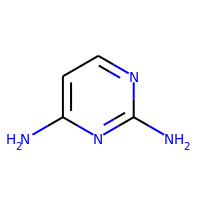
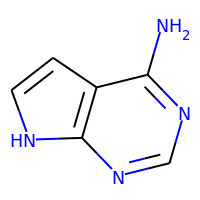
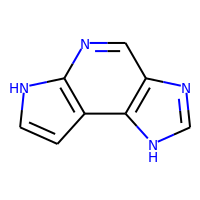
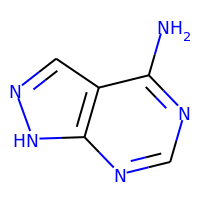
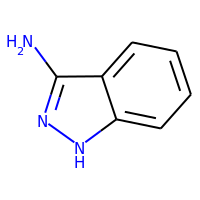

In [10]:
most_common_fragments = get_clustered_most_common_fragments(fragment_library, subpocket)
most_common_fragments.head()

Legend: cluster ID | fragment count


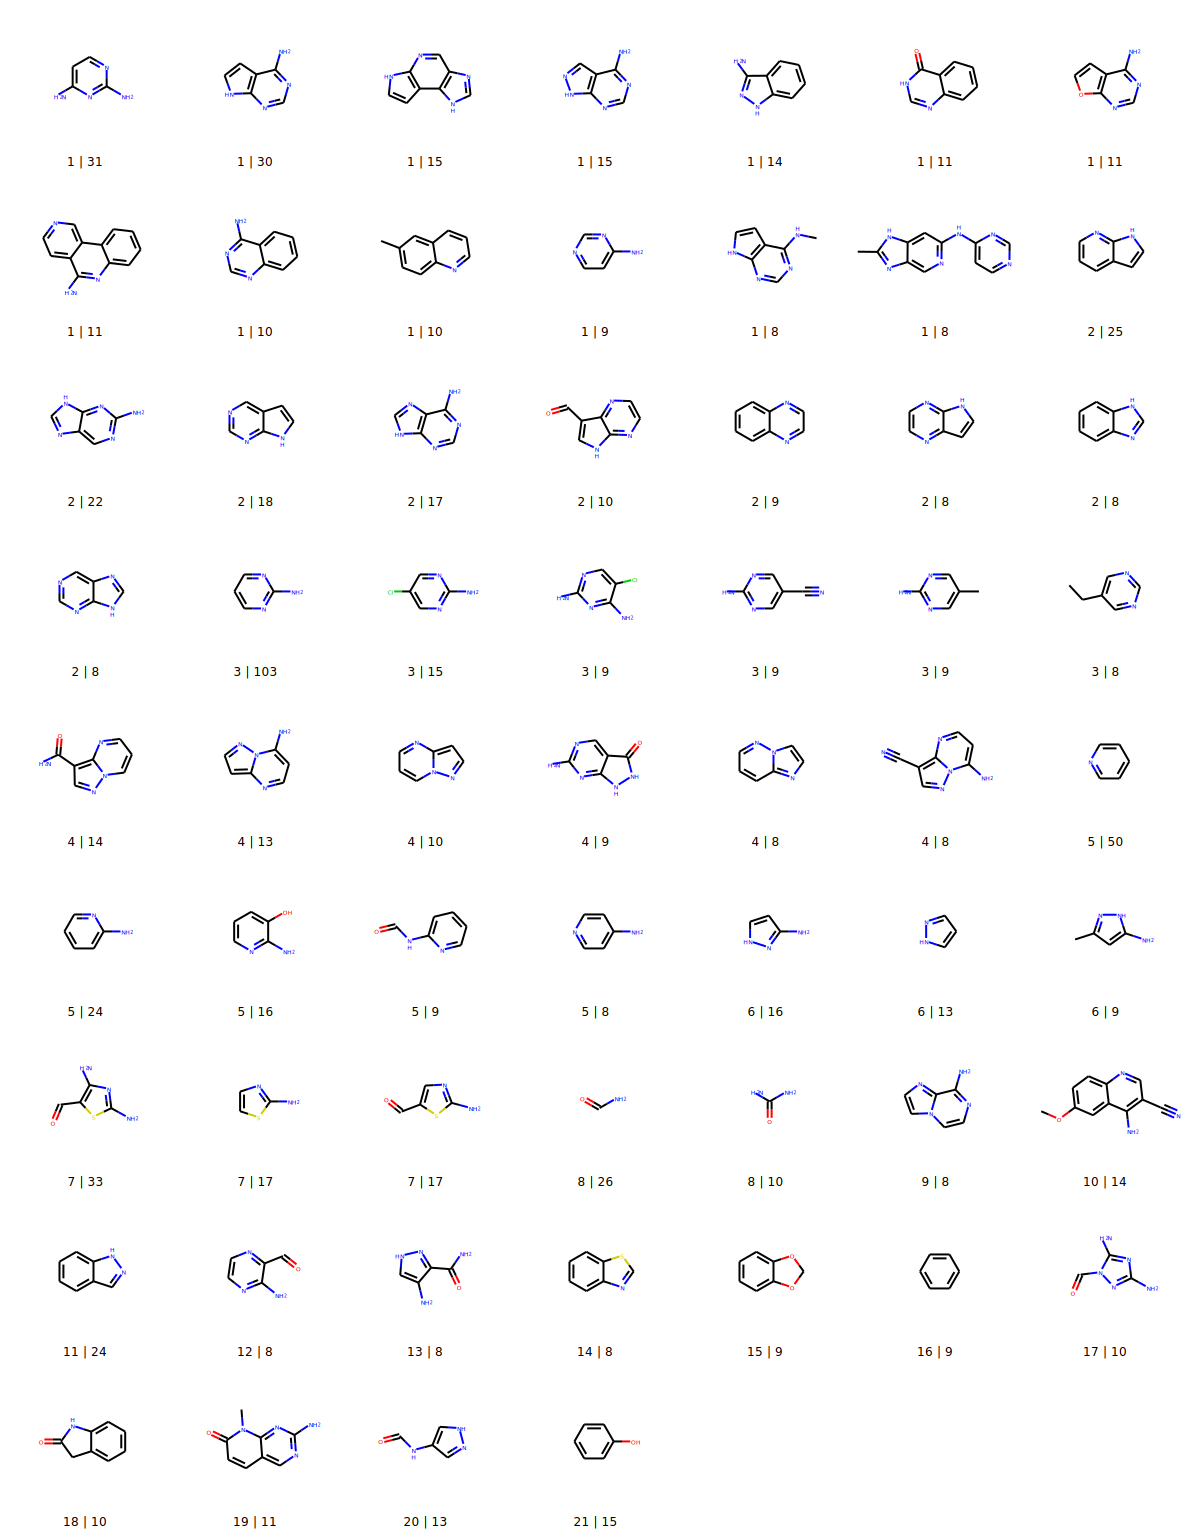

In [11]:
draw_clusters(most_common_fragments, subpocket, OUTPUT_PATH)

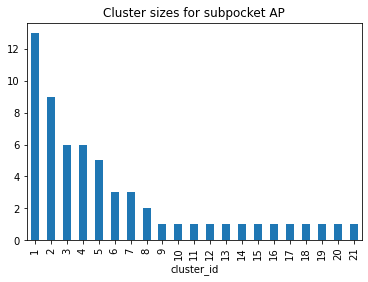

In [12]:
plot_cluster_sizes(most_common_fragments, subpocket)

### Front pocket

In [13]:
subpocket = 'FP'

Number of fragments: 52
Threshold:  0.6
Number of clusters:  26
# clusters with only 1 compound:  13
Legend: cluster ID | fragment count


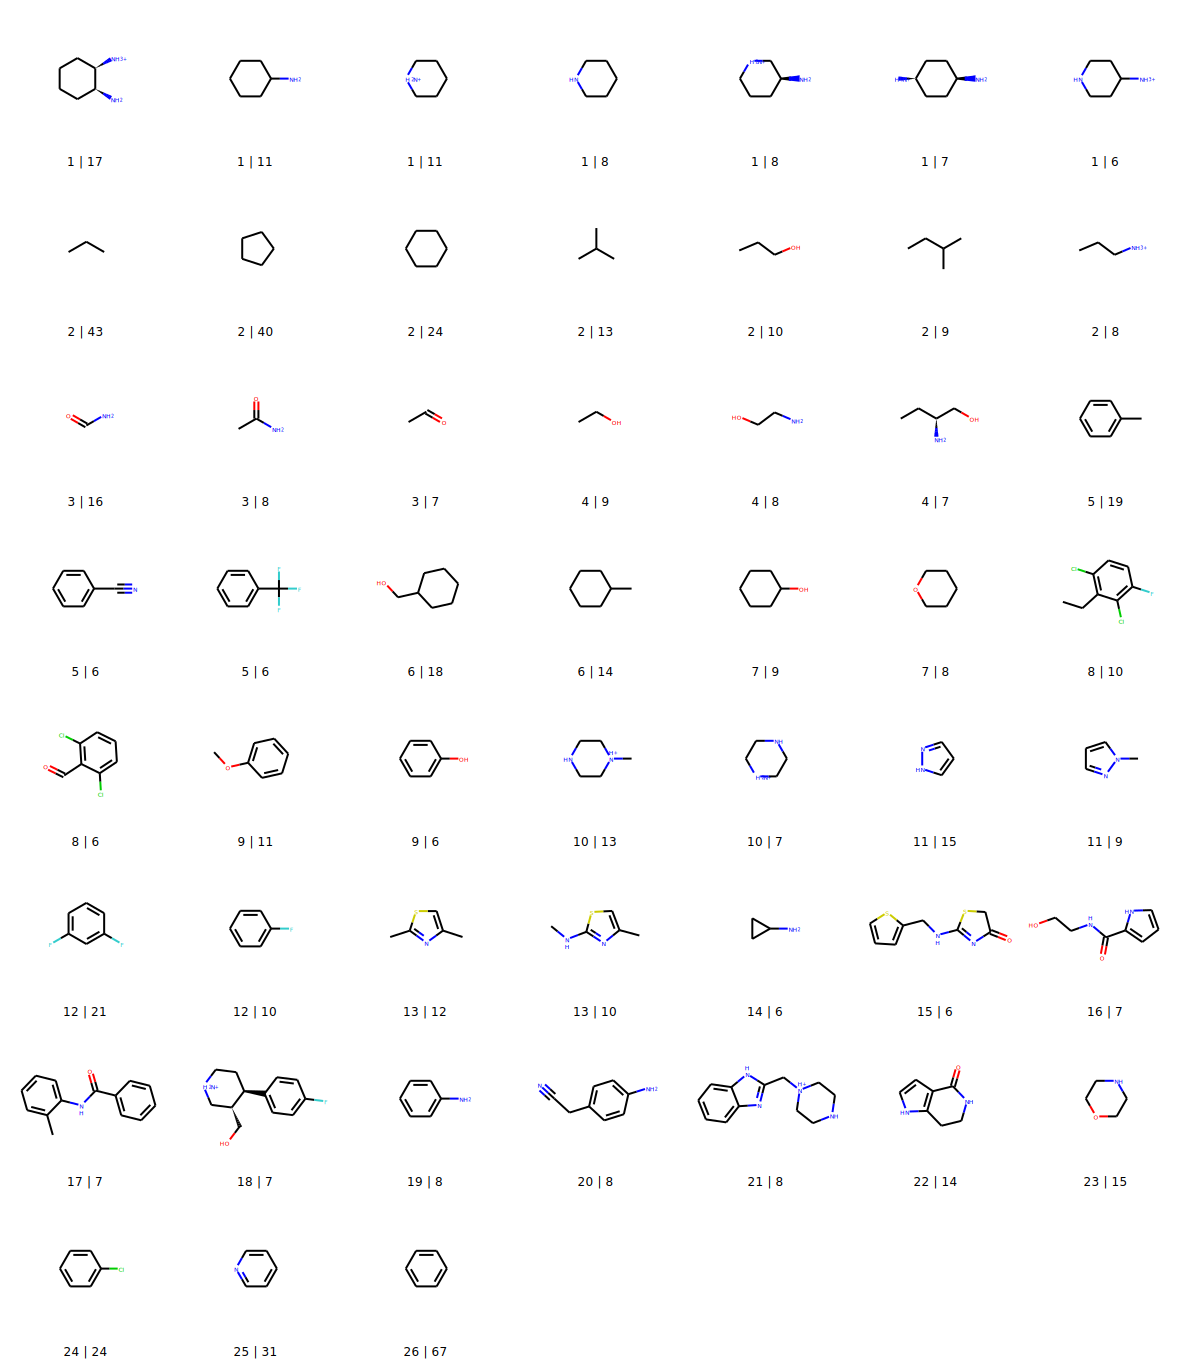

In [14]:
most_common_fragments = get_clustered_most_common_fragments(fragment_library, subpocket)
draw_clusters(most_common_fragments, subpocket, OUTPUT_PATH)

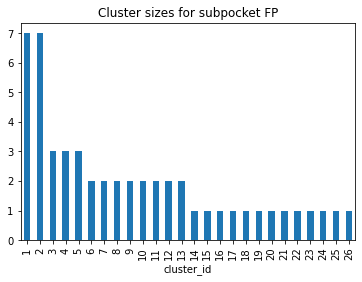

In [15]:
plot_cluster_sizes(most_common_fragments, subpocket)

### Solvent-exposed pocket

In [16]:
subpocket = 'SE'

Number of fragments: 50
Threshold:  0.6
Number of clusters:  25
# clusters with only 1 compound:  13
Legend: cluster ID | fragment count


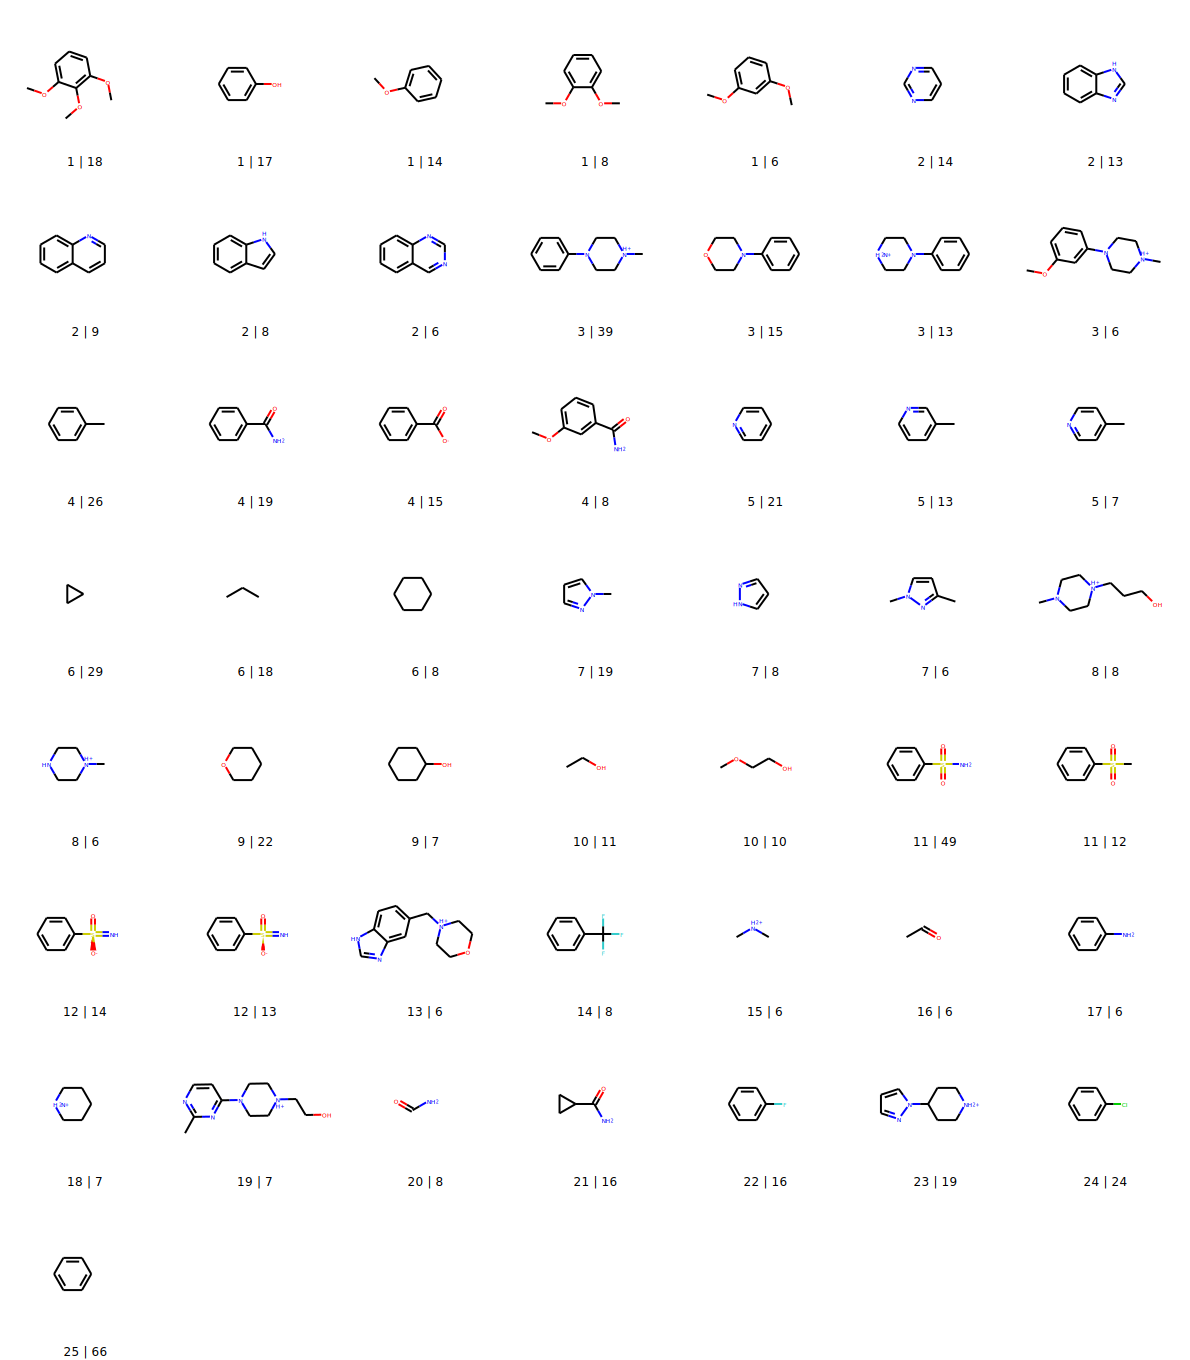

In [17]:
most_common_fragments = get_clustered_most_common_fragments(fragment_library, subpocket)
draw_clusters(most_common_fragments, subpocket, OUTPUT_PATH)

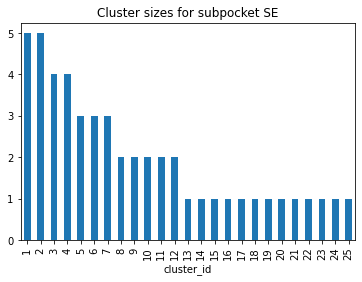

In [18]:
plot_cluster_sizes(most_common_fragments, subpocket)

### Gate area

In [19]:
subpocket = 'GA'

Number of fragments: 51
Threshold:  0.6
Number of clusters:  23
# clusters with only 1 compound:  13
Legend: cluster ID | fragment count


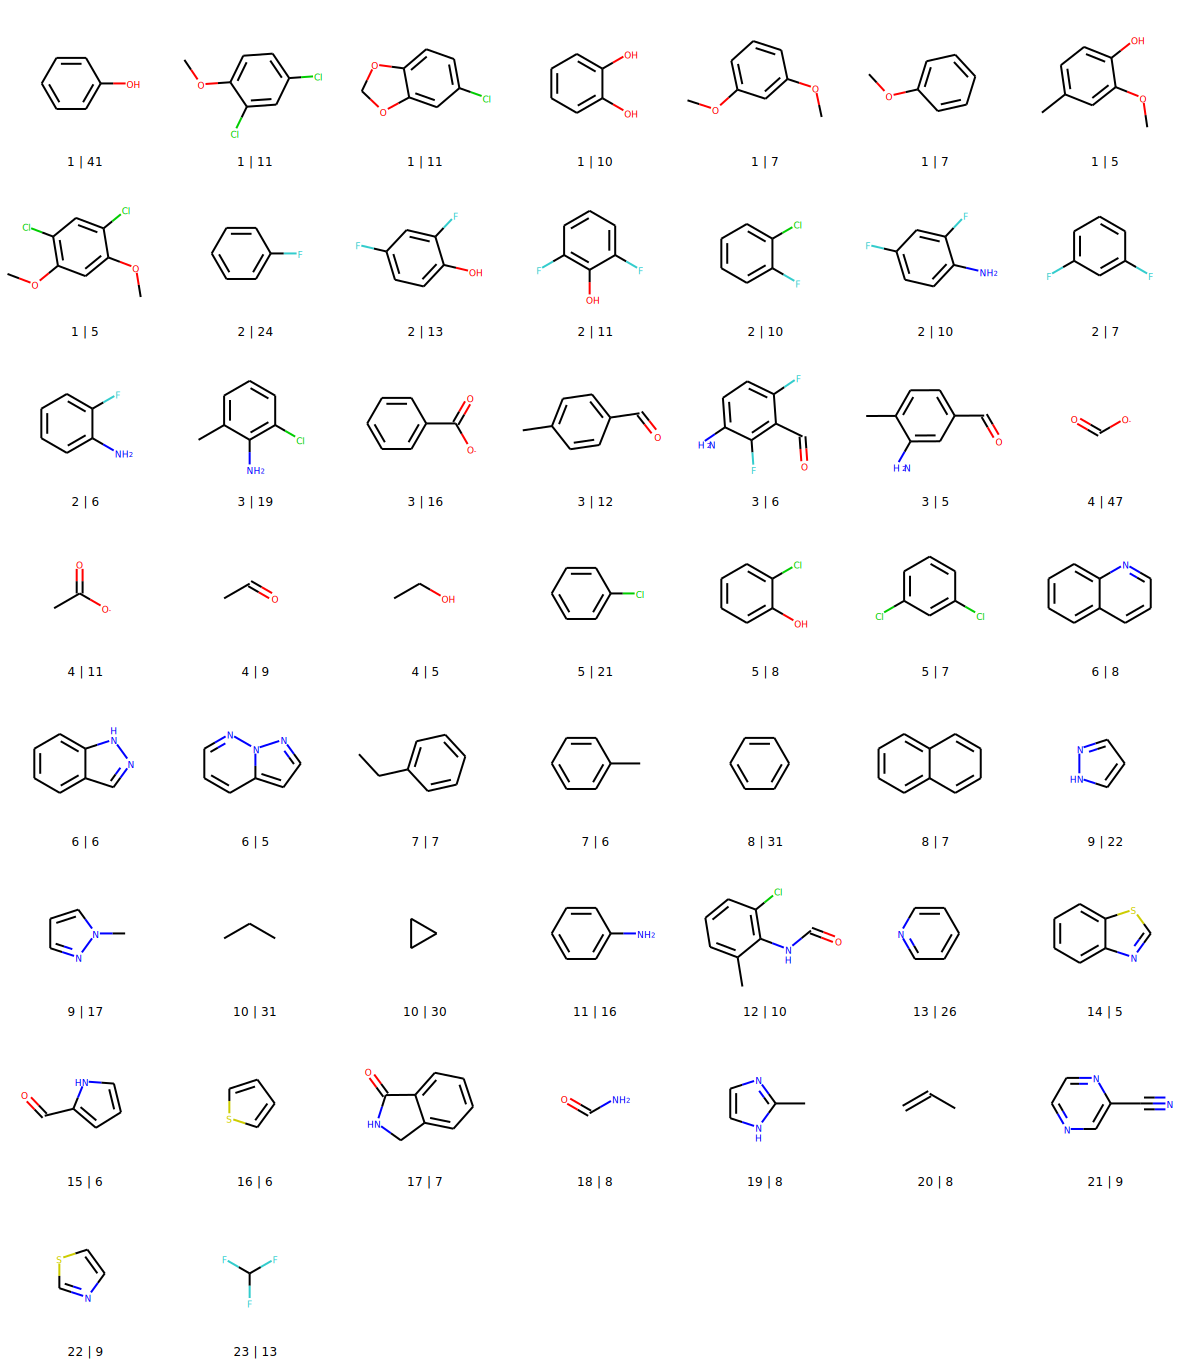

In [20]:
most_common_fragments = get_clustered_most_common_fragments(fragment_library, subpocket)
draw_clusters(most_common_fragments, subpocket, OUTPUT_PATH)

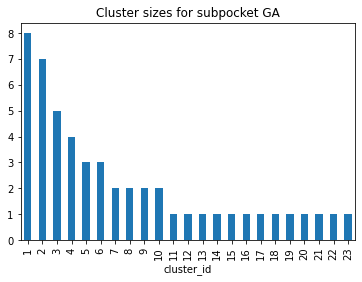

In [21]:
plot_cluster_sizes(most_common_fragments, subpocket)

### Back pocket I

In [22]:
subpocket = 'B1'

Number of fragments: 42
Threshold:  0.6
Number of clusters:  26
# clusters with only 1 compound:  19
Legend: cluster ID | fragment count


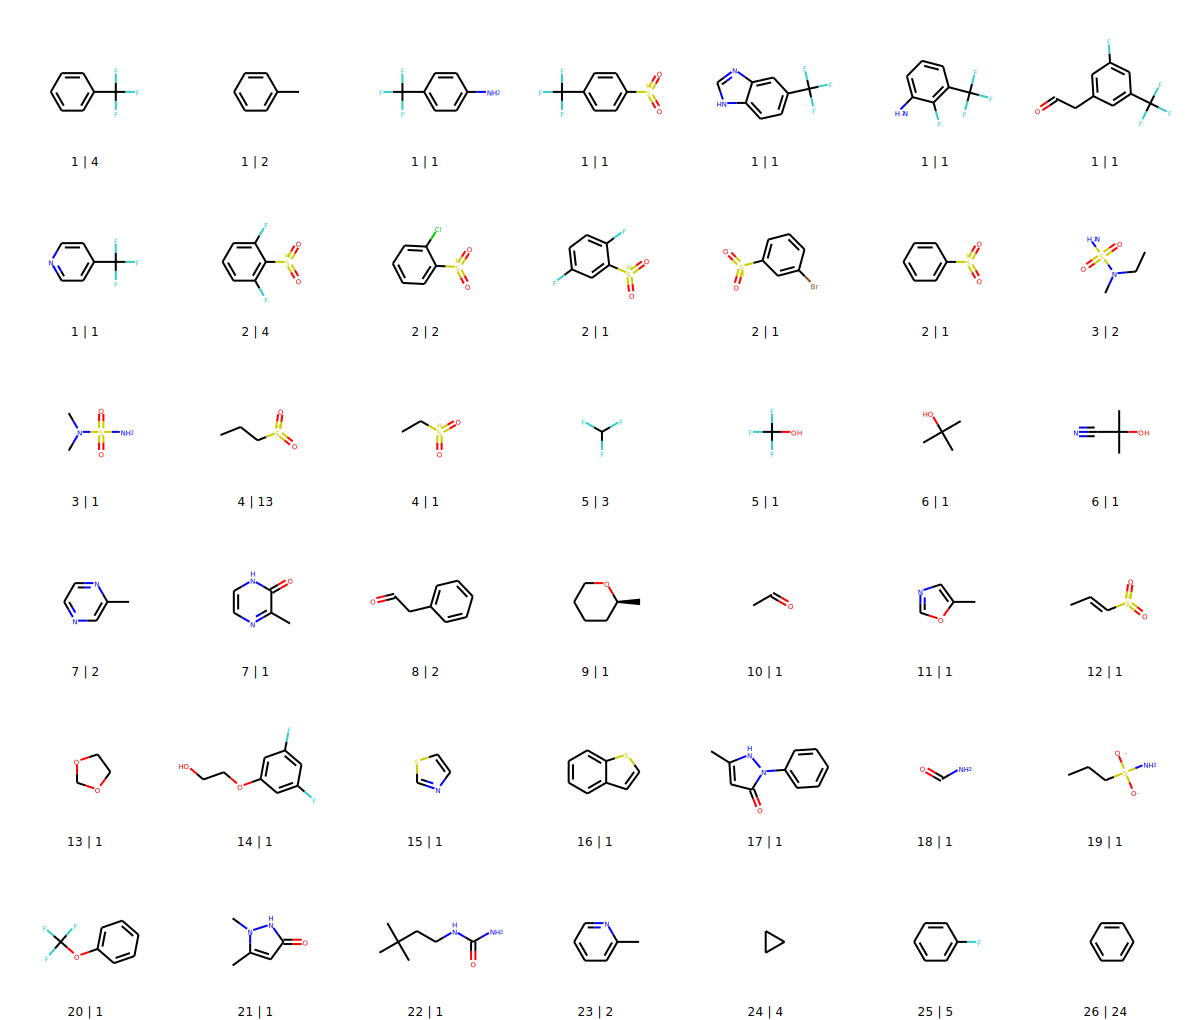

In [23]:
most_common_fragments = get_clustered_most_common_fragments(fragment_library, subpocket)
draw_clusters(most_common_fragments, subpocket, OUTPUT_PATH)

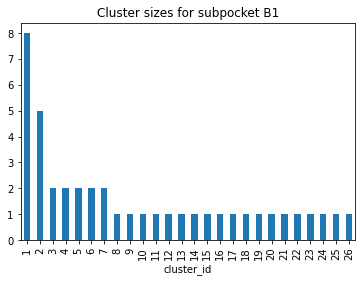

In [24]:
plot_cluster_sizes(most_common_fragments, subpocket)

### Back pocket II

In [25]:
subpocket = 'B2'

Number of fragments: 43
Threshold:  0.6
Number of clusters:  32
# clusters with only 1 compound:  26
Legend: cluster ID | fragment count


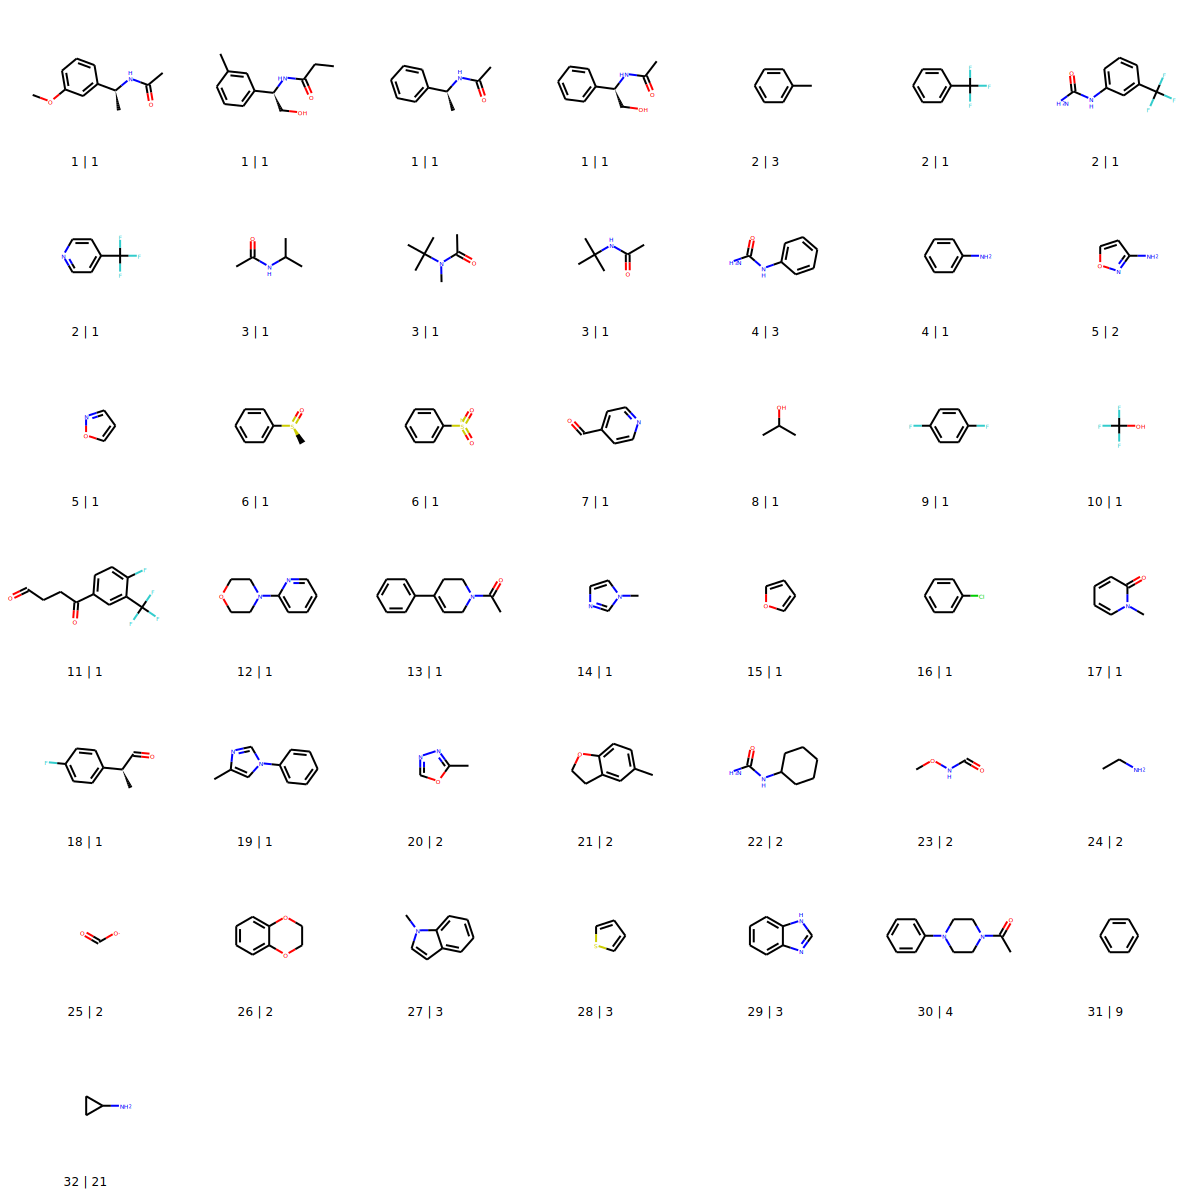

In [26]:
most_common_fragments = get_clustered_most_common_fragments(fragment_library, subpocket)
draw_clusters(most_common_fragments, subpocket, OUTPUT_PATH)

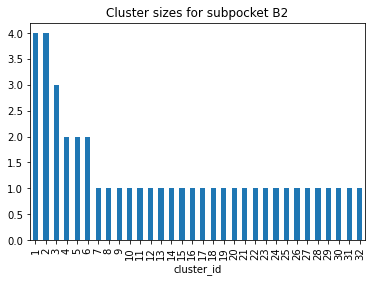

In [27]:
plot_cluster_sizes(most_common_fragments, subpocket)